<a href="https://cognitiveclass.ai"><img src = "https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/Logos/organization_logo/organization_logo.png" width = 400> </a>



<h1 align=center><font size = 5>Обнаружение трещин на фотографиях бетона</font></h1>

### Описание проекта

Обнаружение трещин имеет жизненно важное значение для мониторинга и проверки состояния конструкций. В этой работе мы создадим классификатор с использованием предварительно обученной модели, которая будет обнаруживать трещины на изображениях бетона. Для постановки задачи будем обозначать изображения бетона с трещинами положительным классом, а изображения бетона без трещин — отрицательным классом.

### Цель

Использовать предварительно обученные модели `ResNet50` и `VGG16` для построения классификаторов изображений вместо создания модели с нуля.

<h1><span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Описание-проекта" data-toc-modified-id="Описание-проекта-0.1"><span class="toc-item-num">0.1&nbsp;&nbsp;</span>Описание проекта</a></span></li><li><span><a href="#Цель" data-toc-modified-id="Цель-0.2"><span class="toc-item-num">0.2&nbsp;&nbsp;</span>Цель</a></span></li><li><span><a href="#Импорт-библиотек-и-пакетов" data-toc-modified-id="Импорт-библиотек-и-пакетов-0.3"><span class="toc-item-num">0.3&nbsp;&nbsp;</span>Импорт библиотек и пакетов</a></span></li><li><span><a href="#Определение-глобальных-констант" data-toc-modified-id="Определение-глобальных-констант-0.4"><span class="toc-item-num">0.4&nbsp;&nbsp;</span>Определение глобальных констант</a></span></li></ul></li><li><span><a href="#ResNet50" data-toc-modified-id="ResNet50-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>ResNet50</a></span><ul class="toc-item"><li><span><a href="#Загрузка-данных" data-toc-modified-id="Загрузка-данных-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Загрузка данных</a></span></li><li><span><a href="#Создание-экземпляров-ImageDataGenerator" data-toc-modified-id="Создание-экземпляров-ImageDataGenerator-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Создание экземпляров ImageDataGenerator</a></span></li><li><span><a href="#Построение,-компиляция-и-обучение-модели" data-toc-modified-id="Построение,-компиляция-и-обучение-модели-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Построение, компиляция и обучение модели</a></span></li></ul></li><li><span><a href="#VGG16" data-toc-modified-id="VGG16-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>VGG16</a></span><ul class="toc-item"><li><span><a href="#Загрузка-данных" data-toc-modified-id="Загрузка-данных-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Загрузка данных</a></span></li><li><span><a href="#Создание-экземпляров-ImageDataGenerator" data-toc-modified-id="Создание-экземпляров-ImageDataGenerator-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Создание экземпляров ImageDataGenerator</a></span></li><li><span><a href="#Построение,-компиляция-и-обучение-модели" data-toc-modified-id="Построение,-компиляция-и-обучение-модели-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Построение, компиляция и обучение модели</a></span></li></ul></li><li><span><a href="#Оценим-модели-глубокого-обучения-на-тестовых-данных" data-toc-modified-id="Оценим-модели-глубокого-обучения-на-тестовых-данных-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Оценим модели глубокого обучения на тестовых данных</a></span></li></ul></div>

### Импорт библиотек и пакетов

Установим и импортируем необходимые библиотеки

In [1]:
# Загрузка библиотек
!pip install numpy -q
!pip install pandas -q
!pip install tensorflow -q
!pip install skillsnetwork -q

In [2]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50, VGG16
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.utils import to_categorical
import skillsnetwork

2024-05-20 18:01:18.806748: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Определение глобальных констант

Определим константы, которые будем использовать в проекте.

1. У нас два класса, поэтому *num_classes* равно 2.
2. Модели были построены и обучены с использованием изображений размером (224 x 224). Поэтому нам нужно изменить размер наших изображений с (227 x 227) на (224 x 224).
3. Мы будем обучать и проверять модель, используя пакеты по 100 изображений.

In [3]:
# Определение глобальных констант
num_classes = 2
image_resize = 224
# Задаем размер пакета
batch_size = 100

----

## ResNet50

Создадим классификатор изображений, используя предварительно обученную модель ResNet50

### Загрузка данных

Загрузим данные из хранилища объектов IBM, используя команду **skillsnetwork.prepare**. Команда skillsnetwork.prepare используется для загрузки zip-файла, его распаковки и сохранения в указанном каталоге.

In [4]:
# загрузим данные
await skillsnetwork.prepare("https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DL0321EN-SkillsNetwork/concrete_data_week3.zip", overwrite=True)

  0%|          | 0/30036 [00:00<?, ?it/s]

Saved to '.'


In [5]:
# Проверить содержимое ./concrete_data_week3, выполнив следующую команду:
os.listdir('concrete_data_week3')

['valid', '.DS_Store', 'train']

Мы загрузили папку *concrete_data_week3*, она содержит две папки: *train* и *valid*. Каждая из них содержит две подпапки: *positive* и *negative*, где *negative* - это отрицательный класс, представляющий изображения бетона без трещин, а *positive* - это положительный класс, представляющий изображения бетона с трещинами.

### Создание экземпляров ImageDataGenerator

Keras ImageDataGenerator требует, чтобы изображения располагались в определенной иерархии папок, где основной каталог будет содержать папки, равные количеству классов в нашей задаче. Поскольку в данном случае мы пытаемся построить классификатор из двух классов, то наш основной каталог `concrete_data_week2` должен содержать две папки, по одной для каждого класса, действитель негативные изображения находятся в одной папке, а позитивные изображения — в другой папке.

Продолжим и определим экземпляр Keras ImageDataGenerator.

Для создания экземпляра `ImageDataGenerator` мы установим аргумент **preprocessing_function** равным *preprocess_input*, который мы импортировали из **keras.applications.resnet50** для предварительной обработки наших изображений таким же образом, как обрабатывались изображения, используемые для обучения модели ResNet50.

In [6]:
# Создание экземпляров ImageDataGenerator
data_generator = ImageDataGenerator(
    preprocessing_function=preprocess_input,
)

Далее мы используем методы `flow_from_directory` для пакетного перебора изображений. В этом методе мы передаём каталог, в котором находятся изображения, размер каждого пакета *batch_size*, чтобы изменить размер изображений, используем аргумент *target_size*.

In [7]:
# Загрузка данных для обучения и валидации
train_generator = data_generator.flow_from_directory(
    'concrete_data_week3/train',
    target_size=(image_resize, image_resize),
    batch_size=batch_size,
    class_mode='categorical'
)

Found 10001 images belonging to 2 classes.


Было обнаружено в общей сложности 10 001 изображение, принадлежащих 2 классам.

Для доступа к пакетам мы используем метод `next`:

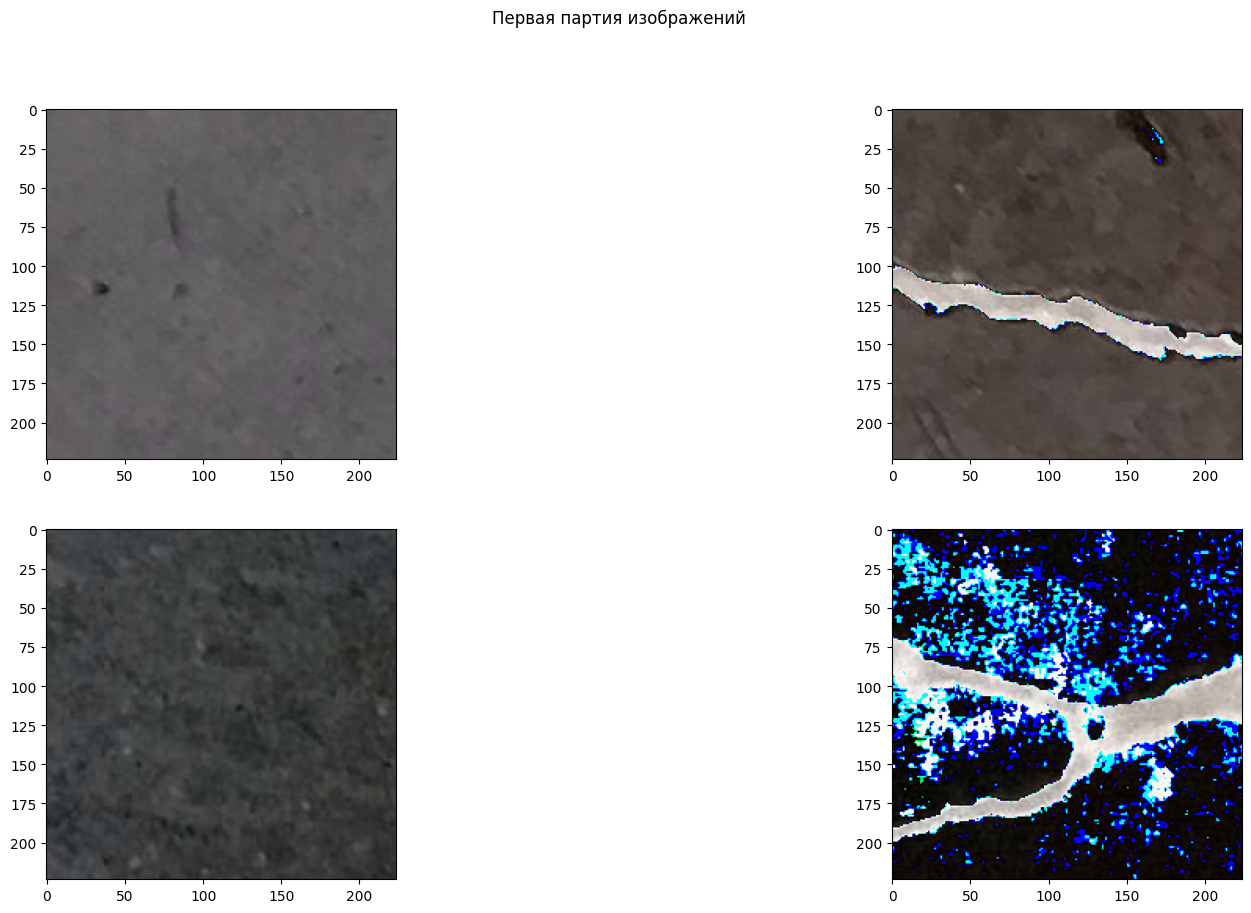

In [8]:
# Визуализация первого пакета изображений
first_batch_images, first_batch_labels = train_generator.next()
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(20, 10))

ind = 0
for ax1 in axs:
    for ax2 in ax1:
        image_data = first_batch_images[ind].astype(np.uint8)
        ax2.imshow(image_data)
        ind += 1

fig.suptitle('Первая партия изображений')
plt.show()

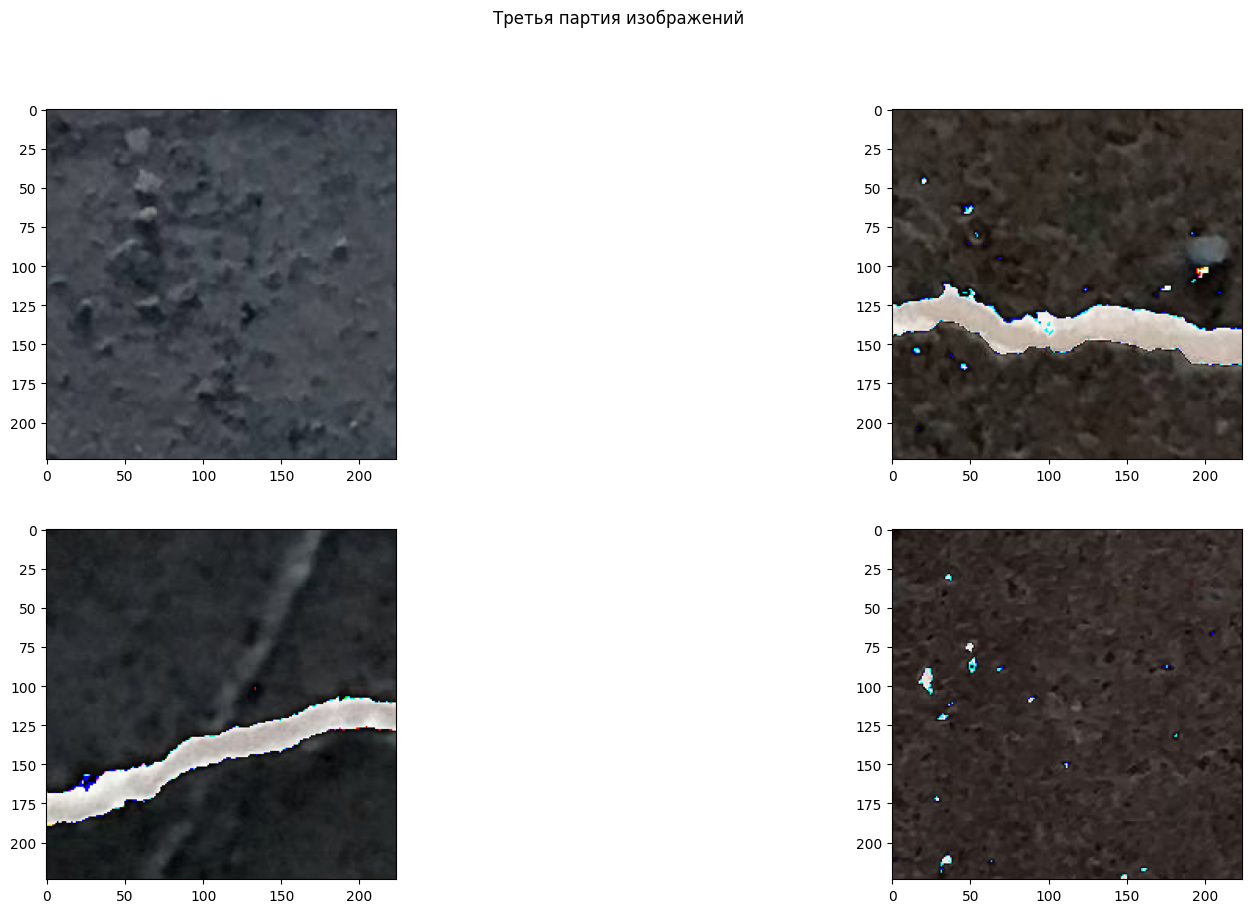

In [9]:
# Визуализация третьего пакета изображений
second_batch_images = train_generator.next()[0]
third_batch_images = train_generator.next()[0]

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(20, 10))

ind = 0
for ax1 in axs:
    for ax2 in ax1:
        image_data = third_batch_images[ind].astype(np.uint8)
        ax2.imshow(image_data)
        ind += 1

fig.suptitle('Третья партия изображений')
plt.show()

In [10]:
# Сколько изображений каждого класса в четвертом пакете?
fourth_batch_labels = train_generator.next()[1]
num_positive = np.sum(fourth_batch_labels[:, 1] == 1)
num_negative = np.sum(fourth_batch_labels[:, 0] == 1)

print("Количество положительных изображений классов в четвертом пакете:", num_positive)
print("Количество изображений негативного класса в четвертом пакете:", num_negative)

Количество положительных изображений классов в четвертом пакете: 51
Количество изображений негативного класса в четвертом пакете: 49


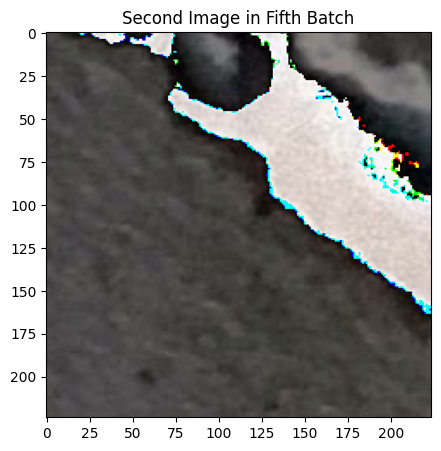

In [11]:
# Визуализация второго изображения в пятом пакете
fifth_batch_images = train_generator.next()[0]

fig, ax = plt.subplots(figsize=(5, 5))
image_data = fifth_batch_images[1].astype(np.uint8)
ax.imshow(image_data)
ax.set_title('Second Image in Fifth Batch')
plt.show()

In [12]:
# Сколько изображений каждого класса в пятом пакете?
fifth_batch_labels = train_generator.next()[1]
num_positive = np.sum(fifth_batch_labels[:, 1] == 1)
num_negative = np.sum(fifth_batch_labels[:, 0] == 1)

print("Количество положительных изображений классов в пятом пакете:", num_positive)
print("Количество изображений негативного класса в пятом пакете:", num_negative)

Количество положительных изображений классов в пятом пакете: 46
Количество изображений негативного класса в пятом пакете: 54


Преобразуем целевую переменную в бинарные категории

In [13]:
train_labels = to_categorical(train_generator.labels)

Затем мы будем использовать метод *flow_from_directory* для получения изображений для обучения следующим образом:

Используя метод *flow_from_directory* для получения изображений для валидации и присвоим результат переменной **validation_generator**.

In [14]:
# Загрузка данных для валидации
validation_generator = data_generator.flow_from_directory(
    'concrete_data_week3/valid',
    target_size=(image_resize, image_resize),
    batch_size=batch_size,
    class_mode='categorical'
)

validation_labels = to_categorical(validation_generator.labels)

Found 5001 images belonging to 2 classes.


### Построение, компиляция и обучение модели

Начнем создавать нашу модель, используя класс Sequential из Keras.

Добавим предварительно обученную модель ResNet50 к нашей модели. Однако, мы не хотим включать верхний слой или выходной слой предварительно обученной модели. Фактически, мы хотим определить свой собственный выходной слой и обучить его так, чтобы он был оптимизирован для нашего набора изображений. Для того чтобы исключить выходной слой предварительно обученной модели, мы будем использовать аргумент *include_top* и установим его в **False**.

In [15]:
# Построение модели
model = Sequential()
model.add(ResNet50(
    include_top=False,
    pooling='avg',
    weights='imagenet'
))
model.add(Dropout(0.5))

Затем определим наш выходной слой как слой **Dense**, состоящий из двух узлов и использующий функцию активации **Softmax**.

In [16]:
model.add(Dense(num_classes, activation='softmax'))

Мы можем получить доступ к слоям модели, используя атрибут *layers* объекта нашей модели.

In [17]:
model.layers

Мы видим, что наша модель состоит из двух наборов слоев. Первый набор - это слои, относящиеся к ResNet50, а второй набор - это один слой, который представляет собой нашу плотную (Dense) слой, который мы определили ранее.

Можем получить доступ к слоям ResNet50, запустив следующий код:

In [18]:
model.layers[0].layers

Поскольку модель ResNet50 уже была обучена, мы хотим сообщить нашей модели не обучать часть ResNet, а обучать только наш выходной плотный слой. Для этого мы выполняем следующий код.

In [19]:
# Замораживание слоев ResNet50
model.layers[0].trainable = False

И теперь, используя атрибут *summary* модели, мы можем увидеть, сколько параметров нам нужно оптимизировать, чтобы обучить выходной слой.

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 2)                 4098      
                                                                 
Total params: 23,591,810
Trainable params: 4,098
Non-trainable params: 23,587,712
_________________________________________________________________


Затем мы компилируем нашу модель, используя оптимизатор **adam**.

In [21]:
# Компиляция модели
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Прежде чем мы сможем начать процесс обучения с использованием ImageDataGenerator, нам нужно определить, сколько шагов составляют одну эпоху. Обычно это число изображений, разделенное на размер пакета. Таким образом, мы определяем количество шагов на эпоху следующим образом:

In [22]:
# Обучение модели
steps_per_epoch_training = len(train_generator)
steps_per_epoch_validation = len(validation_generator)
num_epochs = 2

Наконец, мы готовы начать обучение нашей модели

In [23]:
fit_history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch_training,
    epochs=num_epochs,
    validation_data=validation_generator,
    validation_steps=steps_per_epoch_validation,
    verbose=1
)

Epoch 1/2


2024-05-20 18:03:04.291433: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


101/101 [==============================] - ETA: 0s - loss: 0.0901 - accuracy: 0.9630

2024-05-20 18:13:52.448505: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


101/101 [==============================] - 965s 10s/step - loss: 0.0901 - accuracy: 0.9630 - val_loss: 0.0132 - val_accuracy: 0.9958
Epoch 2/2
101/101 [==============================] - 956s 9s/step - loss: 0.0147 - accuracy: 0.9957 - val_loss: 0.0090 - val_accuracy: 0.9974


Поскольку обучение может занимать много времени при построении моделей глубокого обучения, лучше сохранить модель после завершения обучения

In [24]:
# Сохранение модели
model.save('classifier_resnet_model.h5')

# Проверка корректности сохранения модели
if os.path.exists('classifier_resnet_model.h5'):
    print("Модель успешно сохранена!")
else:
    print("Ошибка при сохранении модели.")

classifier_resnet_model = model

Модель успешно сохранена!


Теперь, когда модель обучена, мы готовы начать использовать её для классификации изображений.

----

## VGG16

Создадим классификатор изображений, используя предварительно обученную модель VGG16

### Загрузка данных

Используем команду `wget` для загрузки данных для по следующему адресу: https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0321EN/data/concrete_data_week4.zip

In [25]:
# загрузим данные
await skillsnetwork.prepare("https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0321EN/data/concrete_data_week4.zip", overwrite=True)

  0%|          | 0/80045 [00:00<?, ?it/s]

Saved to '.'


In [26]:
# Проверим содержимое ./concrete_data_week4, выполнив следующую команду:
os.listdir('concrete_data_week4')

['valid', '.DS_Store', 'test', 'train']

In [27]:
# Определим пути к наборам данных для обучения, валидации и тестирования
train_data_dir = './concrete_data_week4/train'
validation_data_dir = './concrete_data_week4/valid'
test_data_dir = './concrete_data_week4/test'


# Проверим содержимое директорий
print("Contents of train directory:", os.listdir(train_data_dir))
print("Contents of validation directory:", os.listdir(validation_data_dir))
print("Contents of test directory:", os.listdir(test_data_dir))

Contents of train directory: ['positive', '.DS_Store', 'negative']
Contents of validation directory: ['positive', '.DS_Store', 'negative']
Contents of test directory: ['positive', '.DS_Store', 'negative']


После распаковки данных мы обнаружили, что данные уже разделены на наборы для обучения, валидации и тестирования.

Размер изображения: (227, 227, 3)


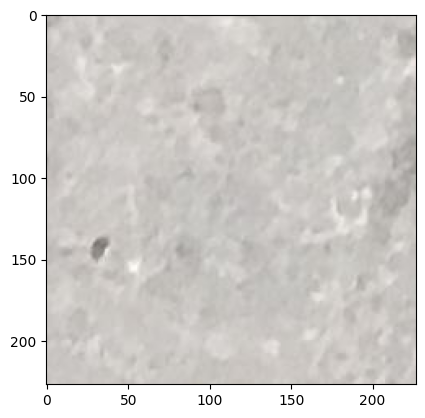

In [28]:
# Используем os.scandir для создания итератора для прохода по каталогу 
# ./concrete_data_week4/train/negative, содержащему все изображения без трещин
negative_files = os.scandir('./concrete_data_week4/train/negative')
# Возьмем первый файл в каталоге
file_name = next(negative_files)
# Считаем элемент, если это файл
os.path.isfile(file_name)
# Получим имя изображения
image_name = str(file_name).split("'")[1]
# Считаем данные изображения
image_data = plt.imread('./concrete_data_week4/train/negative/{}'.format(image_name))
# Каков размер одного изображения согласно **image_data**?
print('Размер изображения:', image_data.shape)
# отобразим изображение
plt.imshow(image_data)

<a id="item42"></a>

### Создание экземпляров ImageDataGenerator

Создадим объект ImageDataGenerator для набора данных для обучения и другой для набора данных для валидации.

In [29]:
# Создаем генераторы изображений для обучающего набора данных
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(image_resize, image_resize),
    batch_size=batch_size,
    class_mode='categorical'
)

Found 30001 images belonging to 2 classes.


In [30]:
# Создаем генераторы изображений для валидационного набора данных
validation_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
validation_generator = validation_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical'
)

Found 9501 images belonging to 2 classes.


### Построение, компиляция и обучение модели

In [31]:
# Создаем последовательную модель
model = Sequential()

In [32]:
# Добавляем модель VGG16 к последовательной модели
model.add(VGG16(weights='imagenet', include_top=False, pooling='avg'))

# Замораживаем слои VGG16
model.layers[0].trainable = False

In [33]:
# Добавляем плотный слой
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 512)               14714688  
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 2)                 514       
                                                                 
Total params: 14,846,530
Trainable params: 131,842
Non-trainable params: 14,714,688
_________________________________________________________________


In [34]:
# Компилируем модель
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [35]:
# Обучаем модель на расширенных данных, используя объекты ImageDataGenerators
fit_history_2 = model.fit(
    train_generator,
    epochs=num_epochs,
    validation_data=validation_generator,
    steps_per_epoch=len(train_generator),
    validation_steps=len(validation_generator)
)

Epoch 1/2


2024-05-20 18:39:06.807194: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


301/301 [==============================] - ETA: 0s - loss: 0.0299 - accuracy: 0.9898 

2024-05-20 19:55:39.082338: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


301/301 [==============================] - 6192s 21s/step - loss: 0.0299 - accuracy: 0.9898 - val_loss: 0.0054 - val_accuracy: 0.9979
Epoch 2/2
301/301 [==============================] - 5910s 20s/step - loss: 0.0080 - accuracy: 0.9977 - val_loss: 0.0075 - val_accuracy: 0.9973


In [36]:
# Сохранение модели
model.save('classifier_vgg16_model.h5')

# Проверка корректности сохранения модели
if os.path.exists('classifier_resnet_model.h5'):
    print("Модель успешно сохранена!")
else:
    print("Ошибка при сохранении модели.")

classifier_vgg16_model = model

Модель успешно сохранена!


----

## Оценим модели глубокого обучения на тестовых данных

Оценим модели глубокого обучения на тестовых данных:

1. Загрузите сохраненную модель, построенную с использованием модели ResNet50.
2. Создайте объект ImageDataGenerator для тестового набора данных. Для этого экземпляра ImageDataGenerator вам нужно передать только каталог тестовых изображений, целевой размер и параметр **shuffle**, установив его в False.
3. Используйте метод **evaluate_generator**, чтобы оценить ваши модели на тестовых данных, передав указанный выше объект ImageDataGenerator в качестве аргумента. Вы можете узнать больше о **evaluate_generator** [здесь](https://keras.io/models/sequential/).
4. Выведите производительность классификатора, используя предварительно обученную модель VGG16.
5. Выведите производительность классификатора, используя предварительно обученную модель ResNet.

In [37]:
# Загрузим сохраненную модель, построенную с использованием модели ResNet50
resnet_model = load_model('classifier_resnet_model.h5')

In [38]:
# Загрузим сохраненную модель, построенную с использованием модели VGG16
classifier_vgg16_model = load_model('classifier_vgg16_model.h5')

In [39]:
# Создадим объект ImageDataGenerator для тестового набора данных
test_datagen = ImageDataGenerator()

test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(224, 224),
    shuffle=False
)

Found 500 images belonging to 2 classes.


In [40]:
# Оценим модели на тестовых данных
resnet_performance = resnet_model.evaluate_generator(test_generator)
print("\nРезультаты работы модели ResNet50:")
print("Потери (Loss):", resnet_performance[0])
print("Точность (Accuracy):", resnet_performance[1])


vgg_performance = classifier_vgg16_model.evaluate_generator(test_generator)
print("Результаты работы модели VGG16:")
print("Потери (Loss):", vgg_performance[0])
print("Точность (Accuracy):", vgg_performance[1])

/var/folders/nq/7d3hmpdn6v5081cpqms7qf4h0000gn/T/ipykernel_24159/2706675296.py:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  resnet_performance = resnet_model.evaluate_generator(test_generator)
2024-05-20 22:00:55.173292: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]



Результаты работы модели ResNet50:
Потери (Loss): 0.04827273264527321
Точность (Accuracy): 0.984000027179718


/var/folders/nq/7d3hmpdn6v5081cpqms7qf4h0000gn/T/ipykernel_24159/2706675296.py:8: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  vgg_performance = classifier_vgg16_model.evaluate_generator(test_generator)
2024-05-20 22:01:27.786024: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


Результаты работы модели VGG16:
Потери (Loss): 0.2876531779766083
Точность (Accuracy): 0.9240000247955322


<a id="item44"></a>

**Предскажем, являются ли изображения в тестовых данных изображениями треснутого бетона или нет?**

In [41]:
# Предсказание класса изображений в тестовых данных с использованием модели VGG16
vgg_predictions = classifier_vgg16_model.predict_generator(test_generator)
print("\nПрогнозы классов первых пяти изображений в тестовом наборе с использованием предварительно обученной модели VGG16:")
for i in range(5):
    if vgg_predictions[i][0] > 0.5:
        print("Positive")
    else:
        print("Negative")

/var/folders/nq/7d3hmpdn6v5081cpqms7qf4h0000gn/T/ipykernel_24159/1546692879.py:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  vgg_predictions = classifier_vgg16_model.predict_generator(test_generator)
2024-05-20 22:02:30.908646: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]



Прогнозы классов первых пяти изображений в тестовом наборе с использованием предварительно обученной модели VGG16:
Positive
Positive
Positive
Positive
Positive


In [42]:
# Предсказание класса изображений в тестовых данных с использованием модели ResNet50
resnet_predictions = resnet_model.predict_generator(test_generator)
print("\nПрогнозы классов первых пяти изображений в тестовом наборе с использованием предварительно обученной модели ResNet50:")
for i in range(5):
    if resnet_predictions[i][0] > 0.5:
        print("Positive")
    else:
        print("Negative")

/var/folders/nq/7d3hmpdn6v5081cpqms7qf4h0000gn/T/ipykernel_24159/1410175441.py:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  resnet_predictions = resnet_model.predict_generator(test_generator)
2024-05-20 22:03:39.158715: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]



Прогнозы классов первых пяти изображений в тестовом наборе с использованием предварительно обученной модели ResNet50:
Positive
Positive
Positive
Positive
Positive


Данная работа была выполнена в рамках курса ["IBM AI Engineering"](https://www.coursera.org/professional-certificates/ai-engineer)

**Авторы курса:**

* Romeo Kienzler
* Joseph Santarcangelo
* Alex Aklson
* Saeed Aghabozorgi
* Samaya Madhavan
* Aije Egwaikhide
* Jeremy Nilmeier

<hr>

Авторские права &copy; 2020 [IBM Developer Skills Network](https://cognitiveclass.ai/?utm_source=bducopyrightlink&utm_medium=dswb&utm_campaign=bdu). Этот блокнот и его исходный код распространяются под условиями [Лицензии MIT](https://bigdatauniversity.com/mit-license/).